# Introdução #
Neste notebook esta sendo abordado a a construção de um modele logistico a fim de prever a probabilidade de obito decorrido de paradas cardiacas, baseado em um dataset que simula riscos cardiacos para diferentes individuos, baseado em seus habitos e histórico de saude. São levados com consideração dados como sexo, idade, diabetes, anemia e etc. 

**Etapa de importação do dataset e importação das bibliotecas que serão usadas.**

In [1]:
#Importação do dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/heart-failure-clinical-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/heart-failure-clinical-data


In [2]:
#Importação das bibliotecas

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
heart_failure_df=pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

In [4]:
heart_failure_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
heart_failure_df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

**No código abaixo estou pré tratando algumas columas e retirando os valores nulos.**

In [6]:
heart_failure_df['CPK']=heart_failure_df['creatinine_phosphokinase']
heart_failure_df['FE']=heart_failure_df['ejection_fraction']
heart_failure_df['pressure']=heart_failure_df['high_blood_pressure']
heart_failure_df['DEATH']=heart_failure_df['DEATH_EVENT']
heart_failure_df=heart_failure_df.drop(['creatinine_phosphokinase','ejection_fraction','high_blood_pressure','DEATH_EVENT'], axis=1)
heart_failure_df=heart_failure_df.dropna(axis=0)


## Pré analise
Com auxilio da bibliotéca Seaborn é foi possivel montar este gráfico de mapa de calor para obter uma matriz de correlação das variáveis para que fosse possivel obter uma overview das variáveis. 


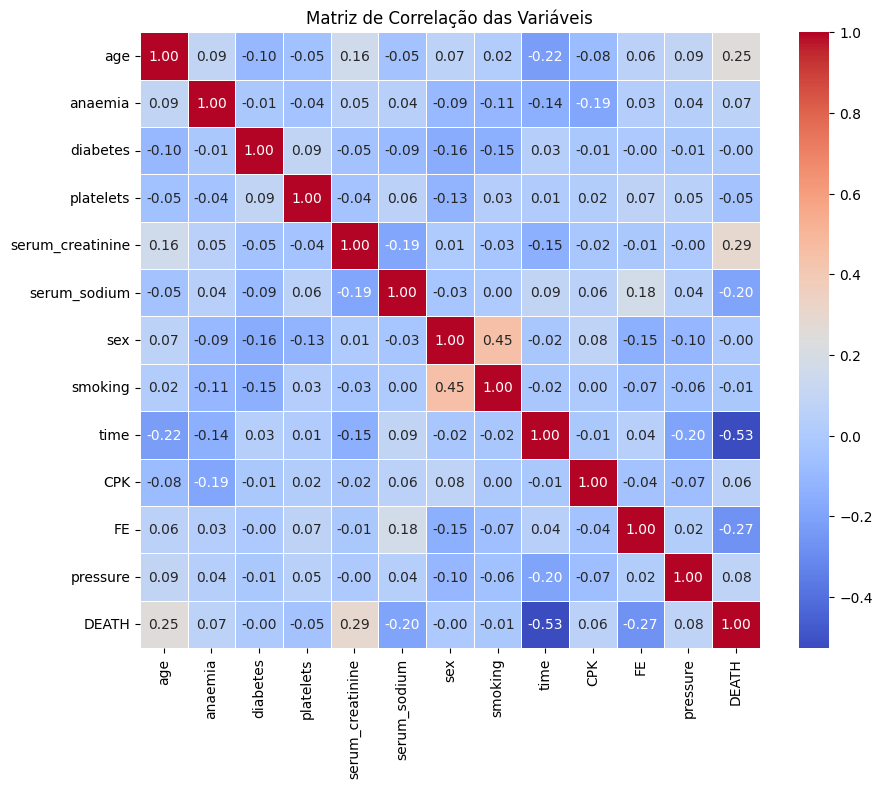

In [7]:
corr = heart_failure_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação das Variáveis")
plt.show()

**Normalizando as variáveis.**

In [8]:
media_1 = heart_failure_df['age'].mean()
desvio_padrao_1 = heart_failure_df['age'].std()
heart_failure_df['age'] = heart_failure_df['age'].apply(lambda x: (x - media_1) / desvio_padrao_1)

media_2 = heart_failure_df['CPK'].mean()
desvio_padrao_2 = heart_failure_df['CPK'].std()
heart_failure_df['CPK'] = heart_failure_df['CPK'].apply(lambda x: (x - media_2) / desvio_padrao_2)

media_3 = heart_failure_df['FE'].mean()
desvio_padrao_3 = heart_failure_df['FE'].std()
heart_failure_df['FE'] = heart_failure_df['FE'].apply(lambda x: (x - media_3) / desvio_padrao_3)

media_4 = heart_failure_df['platelets'].mean()
desvio_padrao_4 = heart_failure_df['platelets'].std()
heart_failure_df['platelets'] = heart_failure_df['platelets'].apply(lambda x: (x - media_4) / desvio_padrao_4)

media_5 = heart_failure_df['serum_creatinine'].mean()
desvio_padrao_5 = heart_failure_df['serum_creatinine'].std()
heart_failure_df['serum_creatinine'] = heart_failure_df['serum_creatinine'].apply(lambda x: (x - media_5) / desvio_padrao_5)

media_6 = heart_failure_df['serum_sodium'].mean()
desvio_padrao_6 = heart_failure_df['serum_sodium'].std()
heart_failure_df['serum_sodium'] = heart_failure_df['serum_sodium'].apply(lambda x: (x - media_6) / desvio_padrao_6)

media_7 = heart_failure_df['time'].mean()
desvio_padrao_7 = heart_failure_df['time'].std()
heart_failure_df['time'] = heart_failure_df['time'].apply(lambda x: (x - media_7) / desvio_padrao_7)


In [9]:
heart_failure_df['male'] = heart_failure_df['sex'].apply(lambda x: 1 if x == 1 else 0)
heart_failure_df['female'] = heart_failure_df['sex'].apply(lambda x: 1 if x == 0 else 0)

heart_failure_df['c_anaemia'] = heart_failure_df['anaemia'].apply(lambda x: 1 if x == 1 else 0)
heart_failure_df['s_anaemia'] = heart_failure_df['anaemia'].apply(lambda x: 0 if x == 1 else 1)

heart_failure_df['c_diabetes'] = heart_failure_df['diabetes'].apply(lambda x: 1 if x == 1 else 0)
heart_failure_df['s_diabetes'] = heart_failure_df['diabetes'].apply(lambda x: 0 if x == 1 else 1)

heart_failure_df['c_smoking'] = heart_failure_df['smoking'].apply(lambda x: 1 if x == 1 else 0)
heart_failure_df['s_smoking'] = heart_failure_df['smoking'].apply(lambda x: 0 if x == 1 else 1)

heart_failure_df['c_pressure'] = heart_failure_df['pressure'].apply(lambda x: 1 if x == 1 else 0)
heart_failure_df['s_pressure'] = heart_failure_df['pressure'].apply(lambda x: 0 if x == 1 else 1)
heart_failure_df=heart_failure_df.drop(['sex', 'pressure','anaemia', 'diabetes','smoking'], axis=1)

In [10]:
heart_failure_df

,age,platelets,serum_creatinine,serum_sodium,time,CPK,FE,DEATH,male,female,c_anaemia,s_anaemia,c_diabetes,s_diabetes,c_smoking,s_smoking,c_pressure,s_pressure
0,1.190949,1.678834e-02,0.489237,-1.501519,-1.626775,0.000165,-1.527998,1,1,0,0,1,0,1,0,1,1,0
1,-0.490457,7.523048e-09,-0.284076,-0.141739,-1.601007,7.502063,-0.007065,1,1,0,0,1,0,1,0,1,0,1
2,0.350246,-1.036336e+00,-0.090748,-1.728149,-1.588122,-0.449186,-1.527998,1,1,0,0,1,0,1,1,0,0,1
3,-0.910808,-5.455595e-01,0.489237,0.084892,-1.588122,-0.485257,-1.527998,1,1,0,1,0,0,1,0,1,0,1
4,0.350246,6.507077e-01,1.262550,-4.674340,-1.575238,-0.434757,-1.527998,1,0,1,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098035,-1.107907e+00,-0.284076,1.444672,1.800432,-0.536789,-0.007065,0,1,0,0,1,1,0,1,0,1,0
295,-0.490457,6.791087e-02,-0.187412,0.538152,1.813317,1.276075,-0.007065,0,0,1,0,1,0,1,0,1,0,1
296,-1.331160,4.893878e+00,-0.574068,0.311522,1.903506,1.523425,1.851853,0,0,1,0,1,1,0,0,1,0,1
297,-1.331160,-1.261275e+00,0.005916,0.764782,1.929275,1.887234,-0.007065,0,1,0,0,1,0,1,1,0,0,1


In [11]:
heart_failure_df

,age,platelets,serum_creatinine,serum_sodium,time,CPK,FE,DEATH,male,female,c_anaemia,s_anaemia,c_diabetes,s_diabetes,c_smoking,s_smoking,c_pressure,s_pressure
0,1.190949,1.678834e-02,0.489237,-1.501519,-1.626775,0.000165,-1.527998,1,1,0,0,1,0,1,0,1,1,0
1,-0.490457,7.523048e-09,-0.284076,-0.141739,-1.601007,7.502063,-0.007065,1,1,0,0,1,0,1,0,1,0,1
2,0.350246,-1.036336e+00,-0.090748,-1.728149,-1.588122,-0.449186,-1.527998,1,1,0,0,1,0,1,1,0,0,1
3,-0.910808,-5.455595e-01,0.489237,0.084892,-1.588122,-0.485257,-1.527998,1,1,0,1,0,0,1,0,1,0,1
4,0.350246,6.507077e-01,1.262550,-4.674340,-1.575238,-0.434757,-1.527998,1,0,1,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098035,-1.107907e+00,-0.284076,1.444672,1.800432,-0.536789,-0.007065,0,1,0,0,1,1,0,1,0,1,0
295,-0.490457,6.791087e-02,-0.187412,0.538152,1.813317,1.276075,-0.007065,0,0,1,0,1,0,1,0,1,0,1
296,-1.331160,4.893878e+00,-0.574068,0.311522,1.903506,1.523425,1.851853,0,0,1,0,1,1,0,0,1,0,1
297,-1.331160,-1.261275e+00,0.005916,0.764782,1.929275,1.887234,-0.007065,0,1,0,0,1,0,1,1,0,0,1


**Treinando o modelo como 0.3 da base.**

In [12]:
predictors_train, predictors_test, target_train, target_test = train_test_split(
    heart_failure_df.drop(['DEATH'], axis=1),
    heart_failure_df['DEATH'],
    test_size=0.3,  
    random_state=123
)

**Alimentando o modelo com dados de treino.**

In [13]:
model = LogisticRegression()
model_v2=model.fit(predictors_train, target_train)
target_predicted = model.predict(predictors_test)
model.__dict__

{'penalty': 'l2',
 'dual': False,
 'tol': 0.0001,
 'C': 1.0,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': None,
 'solver': 'lbfgs',
 'max_iter': 100,
 'multi_class': 'auto',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': None,
 'l1_ratio': None,
 'feature_names_in_': array(['age', 'platelets', 'serum_creatinine', 'serum_sodium', 'time',
        'CPK', 'FE', 'male', 'female', 'c_anaemia', 's_anaemia',
        'c_diabetes', 's_diabetes', 'c_smoking', 's_smoking', 'c_pressure',
        's_pressure'], dtype=object),
 'n_features_in_': 17,
 'classes_': array([0, 1]),
 'n_iter_': array([21], dtype=int32),
 'coef_': array([[ 5.16592609e-01, -2.58585088e-01,  5.08862214e-01,
         -2.33054893e-01, -1.81441470e+00,  1.43660491e-01,
         -7.80457410e-01, -3.83235452e-01,  3.83227611e-01,
         -1.66306640e-01,  1.66298799e-01,  1.67611581e-03,
         -1.68395674e-03, -1.05914492e-01,  1.05906651e-01,
         -2.83783750e-02,  2.83705341e-

**Validando a acurácia do modelo.**

In [14]:
print("Accuracy:", accuracy_score(target_test, target_predicted))
print("F1 Score:", f1_score(target_test, target_predicted))
print("AUC-ROC:", roc_auc_score(target_test, target_predicted))

Accuracy: 0.7888888888888889
F1 Score: 0.6984126984126985
AUC-ROC: 0.7595614482406936


In [15]:
 heart_failure_df.columns

Index(['age', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'CPK',
       'FE', 'DEATH', 'male', 'female', 'c_anaemia', 's_anaemia', 'c_diabetes',
       's_diabetes', 'c_smoking', 's_smoking', 'c_pressure', 's_pressure'],
      dtype='object')

In [16]:
novo_dado = [60, 250000, 1.0, 130, 4, 120, 20, 1, 0, 0, 1, 0, 1, 1, 0,1,0]

novo_dado[0] = (novo_dado[0] - media_1) / desvio_padrao_1  # age
novo_dado[1] = (novo_dado[1] - media_2) / desvio_padrao_2  # CPK
novo_dado[2] = (novo_dado[2] - media_3) / desvio_padrao_3  # FE
novo_dado[3] = (novo_dado[3] - media_4) / desvio_padrao_4  # platelets
novo_dado[4] = (novo_dado[4] - media_5) / desvio_padrao_5  # serum_creatinine
novo_dado[5] = (novo_dado[5] - media_6) / desvio_padrao_6  # serum_sodium
novo_dado[6] = (novo_dado[6] - media_7) / desvio_padrao_7  # time

In [17]:
individuo = np.array([novo_dado])

In [18]:
print(predictors_train.columns)

Index(['age', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'CPK',
       'FE', 'male', 'female', 'c_anaemia', 's_anaemia', 'c_diabetes',
       's_diabetes', 'c_smoking', 's_smoking', 'c_pressure', 's_pressure'],
      dtype='object')


In [19]:
individuo_df = pd.DataFrame([novo_dado], columns=predictors_train.columns)

# Previsão do risco de morte
risco = model_v2.predict(individuo_df)
probabilidade = model_v2.predict_proba(individuo_df)

print("Classe prevista (risco):", risco[0])
print("Probabilidade por classe:", probabilidade[0])

Classe prevista (risco): 0
Probabilidade por classe: [1.00000000e+00 1.28794741e-32]


## Conclusão

Com base nos resultados, o modelo prevê que o paciente não tem risco de falência cardíaca. A probabilidade de que ele tenha algum risco é praticamente zero, de acordo com as características fornecidas. 
No entanto, é importante lembrar que, embora a previsão seja clara, ela depende de muitos fatores, como a qualidade e quantidade dos dados além da eficácia do modelo.